# CS 763/764 Computer Vision

## Course Project : High quality monocular depth estimation study

#### Literature reference : https://arxiv.org/pdf/1812.11941.pdf

#### List of contents 

* Abstract
* Our work
* Dataset
* Data Pre Processing
* Pytorch loaders

* Training

> * UNet
>> * MSE
>> * L1
>> * SSIM
>> * L1 + SSIM

> * Pretrained Network 
>> * L1 + SSIM

> * Unet ++
>> * L1
>> * SSIM
>> * L1 + SSIM

* 3D Rendering

* Learnings
* Conclusion
* References

## Abstract

Depth estimation has been a classic challenge in computer vision, but the conventional approaches dictate using multiple images in order to estimate depth. This is where deep learning kicks in. Due to advancement in the available computation power, estimating the depth of a single image is a problem that can be solved. The architecture proposed is a U-Net which is based on the architecture of DenseNet-169, input for this network is a single image and output is the depth map for the given image.



## Our Work

We have implemented the code in pytorch for the pretrained model, reference github link : https://github.com/ialhashim/DenseDepth. We examined some different losses which could have been used such as the KL divergence, and tried to incorporate it with the original loss function. Apart from this, we have implemented two architectures derived from U-Net, and examined the effect of loss functions during the training. 

## Dataset

The Dataset used in the original paper is NYU-Depth v2, but due to computation constraints, we have used a smaller subset of this dataset consisting of 1449 Images. This dataset was available in the form of .mat file. 

The link for the same : http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat. 

As shown in the image below, the left image is the input image, and the right most image is the colour coded depth map. This depth map is essentially a number in meters, each pixel value corresponds to the depth of that particular pixel in original image. Brighter the pixel in depth map, farther it is. 

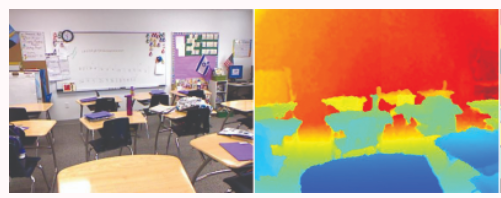

## Data Pre Processing

Since the data is available in .mat file, initially we need to obtain the images and their corresponding depths. For this, we used matlab, and saved the inputs in .jpg format, and the output as well in .jpg format after scaling them to be in the range of 0-255, so that the output is now a grayscale depth map. The input shape is (3, 480, 640) and the output shape is (480, 640). The set of 1449 Images is split into 80-10-10 % ratio into train-validation-test set. The matlab codes are provided below. We have already processed the data using these matlab codes and stored the images and depths in a shared google drive.

> .mat file link : http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

The files to generate the same are provided in the Data Processing folder.

## Pytorch Data Loaders



Importing the libraries.

In [ ]:
import numpy as np
import pandas as pd
import os
import re

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt
from random import random

Specifying the paths

In [ ]:
# All paths
# Mention the paths correctly

data_path = r"../Data"

train_image = os.path.join(data_path,"train/image")
train_label = os.path.join(data_path,"train/labels")

valid_image = os.path.join(data_path,"validation/image")
valid_label = os.path.join(data_path,"validation/labels")

test_image = os.path.join(data_path,"test/image")
test_label = os.path.join(data_path,"test/labels")

sorting the lists so that we have regularly indiced data. The lengths of train, test and validation sets are mentioned as below.

In [ ]:
train_list = sorted(os.listdir(train_image),key=lambda x : int(x[:-4]))
test_list = sorted(os.listdir(test_image),key=lambda x : int(x[:-4]))
valid_list = sorted(os.listdir(valid_image),key=lambda x : int(x[:-4]))

train_label_list = sorted(os.listdir(train_label),key=lambda x : int(x[:-4]))
test_label_list = sorted(os.listdir(test_label),key=lambda x : int(x[:-4]))
valid_label_list = sorted(os.listdir(valid_label),key=lambda x : int(x[:-4]))


print("Length of train samples : ", len(train_list))
print("Length of test samples : ", len(test_list))
print("Length of validation samples : ", len(valid_list))

Length of train samples :  1159
Length of test samples :  145
Length of validation samples :  145


In [ ]:
print("Length of train samples : ", len(train_label_list))
print("Length of test samples : ", len(test_label_list))
print("Length of validation samples : ", len(valid_label_list))

Length of train samples :  1159
Length of test samples :  145
Length of validation samples :  145


Here we performed the augmentation where we flip a coin, if < 0.5, then we flip the image and depth horizontally. Similarly if < 0.5, we invert the channels (R-G-B to B-G-R). 

In [ ]:
class CustomImageDataset(Dataset):

    def __init__(self, label_dir, img_dir,label_list, file_list, transform=None, target_transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.file_list = file_list
        self.label_list = label_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_list[idx])
        image = torchvision.io.read_image(img_path).float()
        
        label_path = os.path.join(self.label_dir, self.label_list[idx])
        label = torchvision.io.read_image(label_path).float()
        
        if random() > 0.5:
          
          image = torch.flip(image, [2])
          label = torch.flip(label, [2])

        if random() > 0.5:
          
          image = torch.flip(image, [0])

        return image, label

In [ ]:
train_dataset = CustomImageDataset(train_label, train_image,train_label_list, train_list)
validation_dataset = CustomImageDataset(valid_label, valid_image, valid_label_list, valid_list)
test_dataset = CustomImageDataset(test_label, test_image, test_label_list, test_list)

In [ ]:
BATCH_SIZE = 1

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)

## Training

### U Net

In [ ]:
class Unet_block(nn.Module):
  
  def __init__(self, in_channel, out_channel):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding = 1)
    self.relu = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding = 1)
    self.bn = nn.BatchNorm2d(out_channel)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.bn(x)
    return x


class Encoder(nn.Module):

  def __init__(self, chs = (3,16, 32, 64, 128)):
    super(Encoder, self).__init__()
    self.chs = chs
    self.enc_blocks = nn.ModuleList([Unet_block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
    self.pool = nn.MaxPool2d(2)
  
  def forward(self, x):
    ftrs = []
    
    for block in self.enc_blocks:
      x = block(x)
      ftrs.append(x)
      x = self.pool(x)

    return ftrs

class Decoder(nn.Module):
  
  def __init__(self, chs=(128, 64, 32, 16), output = 1):
    super().__init__()
    self.chs = chs
    self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
    self.dec_blocks = nn.ModuleList([Unet_block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
    self.dec_final = nn.Conv2d(chs[-1], output, 3, padding=1)

  def forward(self, x, encoder_features):
    for i in range(len(self.chs)-1):
      x        = self.upconvs[i](x)
      x        = torch.cat([x, encoder_features[len(self.chs)-2-i]], dim=1)
      x        = self.dec_blocks[i](x)
    x = self.dec_final(x)
    return x

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,16, 32, 64, 128), dec_chs=(128, 64, 32, 16), num_channels=1):
        super().__init__()
        self.encoder     = Encoder(chs=enc_chs)
        self.decoder     = Decoder(dec_chs, num_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.relu(self.decoder(enc_ftrs[-1], enc_ftrs))
        return out

In [ ]:
def SSIM(Image_1, Image_2, L=255):

  mu_x = torch.mean(Image_1)
  mu_y = torch.mean(Image_2)

  sigma_x = (torch.mean(Image_1*Image_1) - mu_x*mu_x)**0.5
  sigma_y = (torch.mean(Image_2*Image_2) - mu_y*mu_y)**0.5

  cov_xy = torch.mean(Image_1*Image_2) - mu_x*mu_y

  ssim = ((2*mu_x*mu_y + (0.01*L)**2)*(2*cov_xy + (0.03*L)**2)) / ((mu_x**2 + mu_y**2 + (0.01*L)**2)*(sigma_x**2 + sigma_y**2 + (0.03*L)**2))
  return (1 - ssim)/2

In [ ]:
def plot_image(model_x):

  with torch.no_grad():
    X = torchvision.io.read_image('../Data/train/image/125.jpg').float()
    Y = torchvision.io.read_image('../Data/train/labels/125.jpg').float()
    X = X.to(device)
    Y = Y.to(device)

    Y = torch.squeeze(Y, 0)

    X = torch.unsqueeze(X, 0)
    Y_pred = torch.squeeze(model_x(X),0)

    X_dis = torch.squeeze(X, 0).cpu().numpy()
    Y_pred_dis = torch.squeeze(Y_pred,0).cpu().detach().numpy()
    
    figure = plt.figure(figsize=(10,7))

    figure.add_subplot(1,3,1)
    plt.imshow(np.transpose(X_dis, (1,2,0)).astype('int32'))
    plt.axis('off')

    figure.add_subplot(1,3,2)
    plt.imshow(Y.cpu().detach().numpy(), cmap="gray")
    plt.axis('off')

    figure.add_subplot(1,3,3)
    plt.imshow(Y_pred_dis, cmap="gray")
    plt.axis('off')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_2 = UNet()
model_2 = model_2.to(device)

OPTIMIZER = torch.optim.Adam(model_2.parameters(), lr=0.01)

LOSS = SSIM
LOSS_2 = torch.nn.L1Loss()
Metric = torch.nn.MSELoss()

next(model_2.parameters()).is_cuda

True

Initially, taking the loss function as MSE directly

Epoch :  1 Train loss:  0.003439779358993394 Validation loss:  0.0032859204163153966
MSE :  0.003439779358993394  Val :  0.0032859204163153966


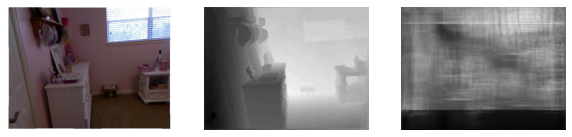

Model saved
Epoch :  2 Train loss:  0.0034253114073834337 Validation loss:  0.003353994673010947
MSE :  0.0034253114073834337  Val :  0.003353994673010947


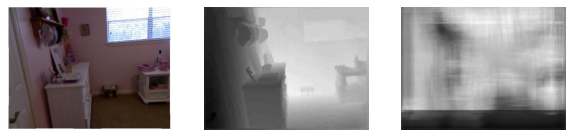

Epoch :  3 Train loss:  0.0034168706559392615 Validation loss:  0.003248211391013244
MSE :  0.0034168706559392615  Val :  0.003248211391013244


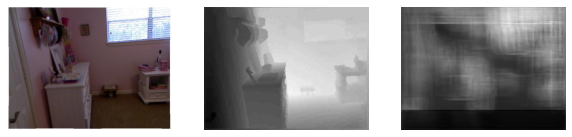

Model saved
Epoch :  4 Train loss:  0.0033815777058149843 Validation loss:  0.0032244811911007454
MSE :  0.0033815777058149843  Val :  0.0032244811911007454


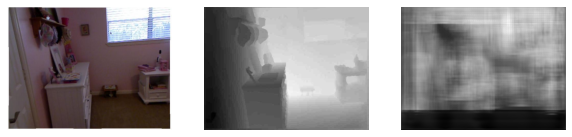

Model saved
Epoch :  5 Train loss:  0.0033663376321095245 Validation loss:  0.0031866153930795605
MSE :  0.0033663376321095245  Val :  0.0031866153930795605


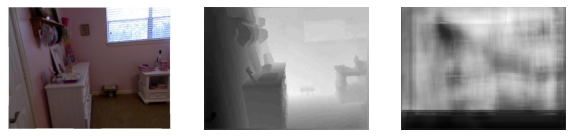

Model saved
Epoch :  6 Train loss:  0.0033785322617963364 Validation loss:  0.004004034039617955
MSE :  0.0033785322617963364  Val :  0.004004034039617955


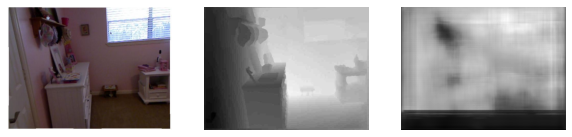

Epoch :  7 Train loss:  0.0033552931036359796 Validation loss:  0.003244584390315516
MSE :  0.0033552931036359796  Val :  0.003244584390315516


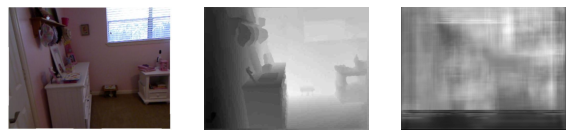

Epoch :  8 Train loss:  0.003321167827723936 Validation loss:  0.003561471484515859
MSE :  0.003321167827723936  Val :  0.003561471484515859


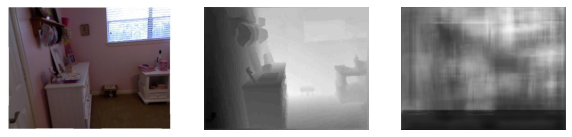

Epoch :  9 Train loss:  0.0032630631336200366 Validation loss:  0.0031026681975044055
MSE :  0.0032630631336200366  Val :  0.0031026681975044055


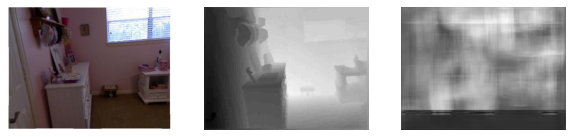

Model saved
Epoch :  10 Train loss:  0.003247454321016722 Validation loss:  0.0031569459220801275
MSE :  0.003247454321016722  Val :  0.0031569459220801275


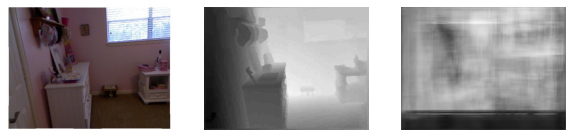

In [ ]:
EPOCHS = 10
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 480*640

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model_2.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model_2(X_train)

    loss = Metric(Y_predict, Y_train)
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += Metric(Y_predict, Y_train).item()

  model_2.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model_2(X_val)

    loss = Metric(Y_val_pred, Y_val)

    loss_aggregate_val += loss.item()
    metric_val += Metric(Y_val_pred, Y_val).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/(len(train_loader)*N_pixels),
        "Validation loss: ", loss_aggregate_val/(len(valid_loader)*N_pixels))
  
  print("MSE : ", metric_train/(len(train_loader)*N_pixels), " Val : ",metric_val/(len(valid_loader)*N_pixels))
  plot_image(model_2)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"..Data/model_11-04-2022_MSE.pt"
    torch.save(model_2.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

Now, L1 loss only.

Epoch :  1 Train loss:  25.506322746754105 Validation loss:  24.661500983402647
MSE :  0.004114167905994657  Val :  0.003945344861725281


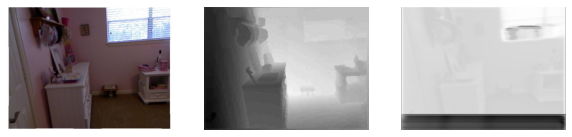

Model saved
Epoch :  2 Train loss:  24.984463493406412 Validation loss:  24.218134518327386
MSE :  0.003951520489586096  Val :  0.0037005981943388096


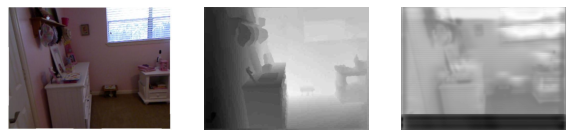

Model saved
Epoch :  3 Train loss:  24.640518687530466 Validation loss:  24.745916271209715
MSE :  0.003836849519470265  Val :  0.004125715101416083


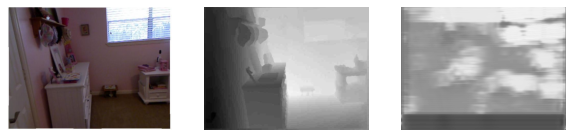

Epoch :  4 Train loss:  24.54524155090964 Validation loss:  23.88346241260397
MSE :  0.003794646571152746  Val :  0.0035595819100566295


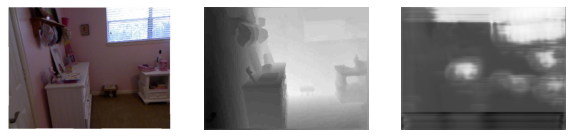

Model saved
Epoch :  5 Train loss:  24.275417020960653 Validation loss:  24.336663680241024
MSE :  0.0037256852366182357  Val :  0.0034816905378267683


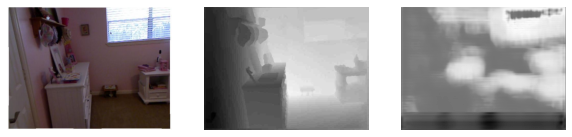

Epoch :  6 Train loss:  24.203531184620235 Validation loss:  23.31980978209397
MSE :  0.0036958663468349587  Val :  0.0034099379664865033


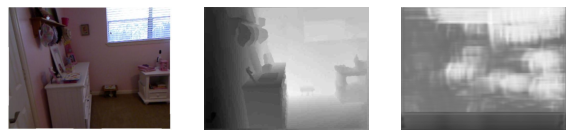

Model saved
Epoch :  7 Train loss:  24.012947585276223 Validation loss:  23.79322067129201
MSE :  0.003643634984297059  Val :  0.0033646859708188594


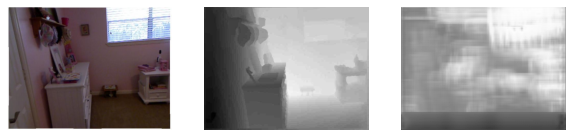

Epoch :  8 Train loss:  23.973437821484517 Validation loss:  24.640462710939605
MSE :  0.003631206380729964  Val :  0.003487763011592558


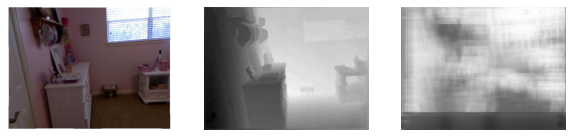

Epoch :  9 Train loss:  23.834990877442774 Validation loss:  23.056121839326003
MSE :  0.0035894766887920424  Val :  0.003427147747113787


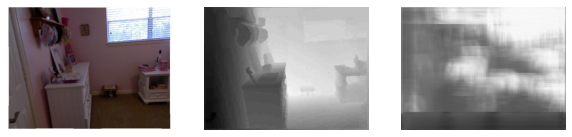

Model saved
Epoch :  10 Train loss:  23.819057339116146 Validation loss:  23.126240118618668
MSE :  0.0036051788972195175  Val :  0.003295072933380631


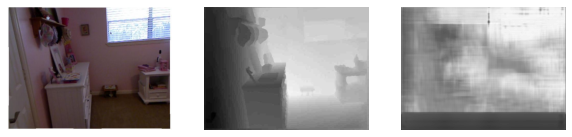

In [ ]:
model_3 = UNet()
model_3 = model_3.to(device)

model_save_path = r"../Data/model_unet_l1.pt"

state = torch.load(model_save_path)

model_3.load_state_dict(state)

OPTIMIZER = torch.optim.Adam(model_3.parameters(), lr=0.01)

EPOCHS = 10
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 480*640

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model_3.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model_3(X_train)

    loss = LOSS_2(Y_predict, Y_train)
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += Metric(Y_predict, Y_train).item()

  model_3.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model_3(X_val)

    loss = LOSS_2(Y_val_pred, Y_val)

    loss_aggregate_val += loss.item()
    metric_val += Metric(Y_val_pred, Y_val).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader),
        "Validation loss: ", loss_aggregate_val/len(valid_loader))
  
  print("MSE : ", metric_train/(len(train_loader)*N_pixels), " Val : ",metric_val/(len(valid_loader)*N_pixels))
  plot_image(model_3)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_11-04-2022_L1.pt"
    torch.save(model_3.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

Only SSIM loss.

Epoch :  1 Train loss:  0.32339786876369075 Validation loss:  0.3226466524189916
MSE :  0.005010807270509332  Val :  0.004675080651524423


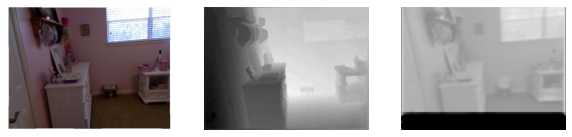

Model saved
Epoch :  2 Train loss:  0.31386162599064954 Validation loss:  0.30851780895529124
MSE :  0.004923752715078825  Val :  0.00469208457141087


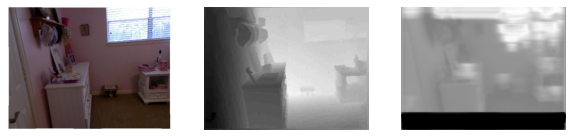

Model saved
Epoch :  3 Train loss:  0.29085282761542525 Validation loss:  0.2822854420234417
MSE :  0.004257795765528845  Val :  0.0038487334422681522


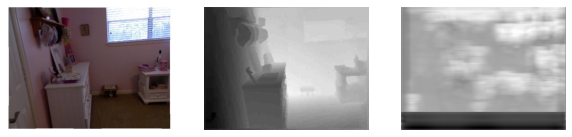

Model saved
Epoch :  4 Train loss:  0.2731420653611036 Validation loss:  0.2762834561282191
MSE :  0.003857099806221868  Val :  0.0036974660312307293


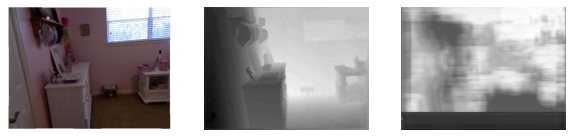

Model saved
Epoch :  5 Train loss:  0.26692343843302097 Validation loss:  0.26607065796852114
MSE :  0.0038120195271727476  Val :  0.0034504747945686867


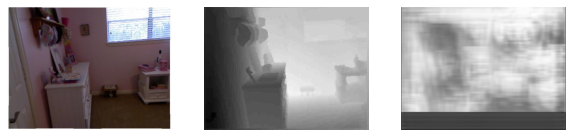

Model saved
Epoch :  6 Train loss:  0.2576509424331787 Validation loss:  0.2534555498895974
MSE :  0.0037163190205943353  Val :  0.0035171985866009506


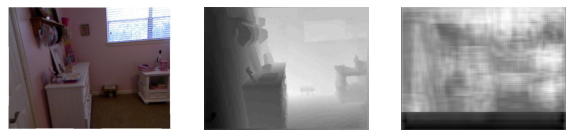

Model saved
Epoch :  7 Train loss:  0.2532804864454722 Validation loss:  0.2655602769605045
MSE :  0.003684929388631237  Val :  0.003446855874924824


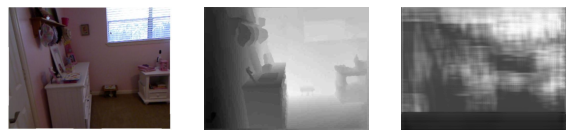

Epoch :  8 Train loss:  0.25320142458696837 Validation loss:  0.2511562526226044
MSE :  0.0036853768015459826  Val :  0.0034340641693822267


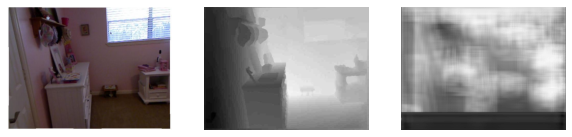

Model saved
Epoch :  9 Train loss:  0.24825929425418944 Validation loss:  0.25044659478911035
MSE :  0.003625995119391312  Val :  0.0034422209252571237


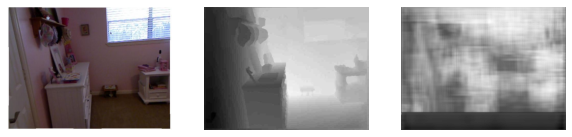

Model saved
Epoch :  10 Train loss:  0.246460517718938 Validation loss:  0.24908684882624396
MSE :  0.003614700064041644  Val :  0.0036286442605243333


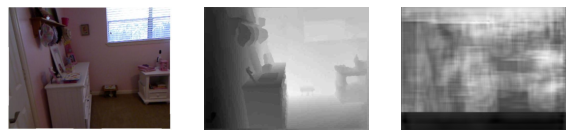

Model saved


In [ ]:
model_4 = UNet()
model_4 = model_4.to(device)

model_save_path = r"../Data/model_unet_ssim.pt"

state = torch.load(model_save_path)

model_4.load_state_dict(state)

OPTIMIZER = torch.optim.Adam(model_4.parameters(), lr=0.01)

EPOCHS = 10
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 480*640

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model_4.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model_4(X_train)

    loss = LOSS(Y_predict, Y_train)
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += Metric(Y_predict, Y_train).item()

  model_4.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model_4(X_val)

    loss = LOSS(Y_val_pred, Y_val)

    loss_aggregate_val += loss.item()
    metric_val += Metric(Y_val_pred, Y_val).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader),
        "Validation loss: ", loss_aggregate_val/len(valid_loader))
  
  print("MSE : ", metric_train/(len(train_loader)*N_pixels), " Val : ",metric_val/(len(valid_loader)*N_pixels))
  plot_image(model_4)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_11-04-2022_SSIM.pt"
    torch.save(model_4.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

Now the best loss, SSIM + L1 Loss.

Epoch :  1 Train loss:  2.8923715498038054 Validation loss:  2.9802549345739955
MSE :  0.004042866083549329  Val :  0.003969150703528832


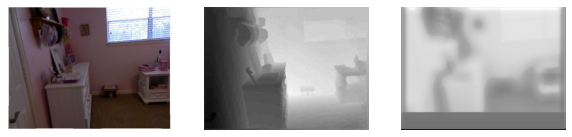

Model saved
Epoch :  2 Train loss:  2.8343305498798723 Validation loss:  2.7810232614648753
MSE :  0.003950022048573231  Val :  0.003819568732517889


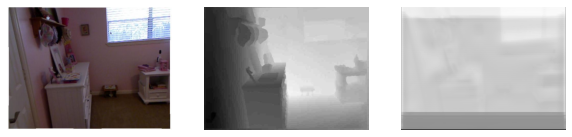

Model saved
Epoch :  3 Train loss:  2.805969320822626 Validation loss:  3.030844587704231
MSE :  0.0038768030731138703  Val :  0.004877979933016602


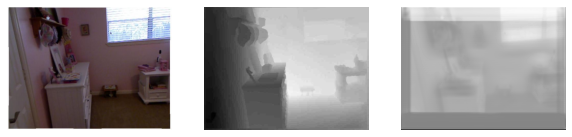

Epoch :  4 Train loss:  2.7846908180028636 Validation loss:  2.70012037260779
MSE :  0.003829414877105212  Val :  0.0035064282997928817


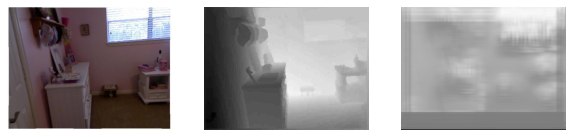

Model saved
Epoch :  5 Train loss:  2.7318493542844 Validation loss:  2.75210346600105
MSE :  0.0037258923473519638  Val :  0.0037193440651071483


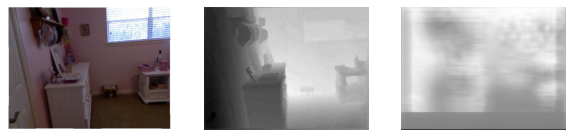

In [ ]:
model_5 = UNet()
model_5 = model_5.to(device)

model_save_path = r"../Data/model_unet_l1_ssim.pt"

state = torch.load(model_save_path)

model_5.load_state_dict(state)

OPTIMIZER = torch.optim.Adam(model_5.parameters(), lr=0.01)

EPOCHS = 5
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 480*640

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model_5.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model_5(X_train)

    loss = LOSS(Y_predict, Y_train) + 0.1*LOSS_2(Y_predict, Y_train)
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += Metric(Y_predict, Y_train).item()

  model_5.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model_5(X_val)

    loss = LOSS(Y_val_pred, Y_val) + 0.1*LOSS_2(Y_val_pred, Y_val)

    loss_aggregate_val += loss.item()
    metric_val += Metric(Y_val_pred, Y_val).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader),
        "Validation loss: ", loss_aggregate_val/len(valid_loader))
  
  print("MSE : ", metric_train/(len(train_loader)*N_pixels), " Val : ",metric_val/(len(valid_loader)*N_pixels))
  plot_image(model_5)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_11-04-2022_SSIM_L1.pt"
    torch.save(model_5.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

Comparing the test accuracy for all the models.

In [54]:
def test(model, test_loader):
  loss_aggregate = 0
  metric_aggregate = 0
  model.train(False)
  for idx, (X_test, Y_test) in enumerate(test_loader):

    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    Y_test_pred = model(X_test)

    # loss = LOSS(Y_test_pred, Y_test) + 0.1*LOSS_2(Y_test_pred, Y_test)

    # loss_aggregate += loss.item()
    metric_aggregate += SSIM(Y_test_pred, Y_val).item()


  print("SSIM loss: ", metric_aggregate/(len(test_loader)))

print("For L1 : ")
test(model_3, test_loader)
print("For SSIM : ")
test(model_4, test_loader)
print("For L1 + SSIM : ")
test(model_5, test_loader)

For L1 : 
SSIM loss:  0.2960210635744292
For SSIM : 
SSIM loss:  0.35286945741752096
For L1 + SSIM : 
SSIM loss:  0.36089020556417006


### U-Net ++

In [28]:
# U-Net ++ Model

"Reference Repository : https://github.com/4uiiurz1/pytorch-nested-unet/blob/master/losses.py"


import torch
from torch import nn

__all__ = ['NestedUNet']


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out
    

class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            
    def getnumberofparams(self,model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            output = 0.25*(output1 + output2 + output3 + output4)
            return output

        else:
            output = self.final(x0_4)
            return output

In [37]:
# Helper functions for deriving the loss functions

from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

# SSIM loss function
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

def scale_invariant_loss(y_pred, y_gt, reg = 0.1):
  d_i = torch.log(torch.flatten(y_pred)) - torch.log(torch.flatten(y_gt))
  v1 = (1/(N_pixels))*(torch.dot(d_i, d_i))
  v2 = (1/(N_pixels**2)*(torch.sum(d_i)**2))
  loss = v1 - reg*v2
  return loss

In [38]:
# Loading the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NestedUNet()
print("Number of Model Parameters : ", model.getnumberofparams(model))
model = model.to(device)

Number of Model Parameters :  9163329


In [39]:
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
l1_criterion = nn.L1Loss()
MSE_LOSS = torch.nn.MSELoss()
METRIC = torch.nn.MSELoss()

In [40]:
LOSS = torch.nn.MSELoss()

#### Training with only SSIM

In [ ]:
torch.cuda.empty_cache()

In [41]:
# Loading the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_save_path = r"/content/drive/Shareddrives/CS764_Computer_Vision_Lab/Project/Models/Dense_Depth_Pretrained.pt"
# state = torch.load(model_save_path)

model = NestedUNet()
print("Number of Model Parameters : ", model.getnumberofparams(model))
model = model.to(device)

Number of Model Parameters :  9163329


In [42]:
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
# LOSS = torch.nn.MSELoss()
l1_criterion = nn.L1Loss()
MSE_LOSS = torch.nn.MSELoss()
METRIC = torch.nn.MSELoss()

Epoch :  1 Train loss:  0.39612008455089703  MSE :  0.012692811548889866 Validation loss:  0.30407358490187547 Val MSE :  0.0057990230698695125


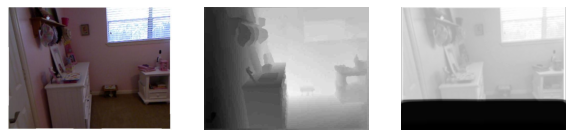

Model saved
Epoch :  2 Train loss:  0.2804937377842055  MSE :  0.004660578603961531 Validation loss:  0.2637061001925633 Val MSE :  0.0037063907336914678


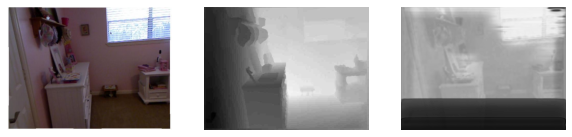

Model saved
Epoch :  3 Train loss:  0.25352556755359673  MSE :  0.0036949852582518314 Validation loss:  0.2514034297959558 Val MSE :  0.0033721332803539846


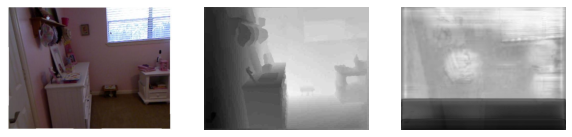

Model saved
Epoch :  4 Train loss:  0.24320245529681675  MSE :  0.0035420561839202575 Validation loss:  0.24160855083630003 Val MSE :  0.003274795271884436


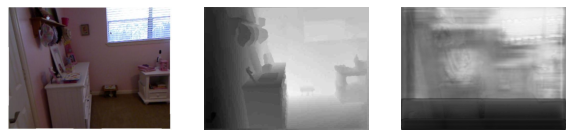

Model saved
Epoch :  5 Train loss:  0.23634713589887973  MSE :  0.0034643240163286493 Validation loss:  0.23153978812283482 Val MSE :  0.003144662398202666


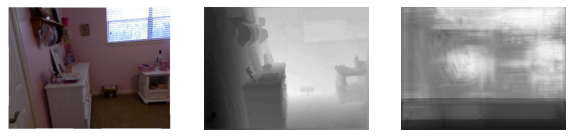

Model saved


In [43]:
EPOCHS = 5
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 4*320*240

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model(X_train)

    # ssim_loss = torch.clamp((1 - ssim(Y_train, Y_predict, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

    loss = SSIM(Y_predict, Y_train)
    
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += METRIC(Y_predict, Y_train).item()

  model.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model(X_val)

    # mse_loss = MSE_LOSS(Y_val_pred, Y_val)

    loss = SSIM(Y_val_pred, Y_val)

    loss_aggregate_val += loss.item()
    metric_val += METRIC(Y_val_pred, Y_val).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader), " MSE : ", metric_train/(len(train_loader)*N_pixels),
        "Validation loss: ", loss_aggregate_val/len(valid_loader), "Val MSE : ", metric_val/(len(valid_loader)*N_pixels))
  
  plot_image(model)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_unetpp_ssim.pt"
    torch.save(model.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

#### Training with a combination of L1 and SSIM

In [ ]:
# Clearing previous cache
torch.cuda.empty_cache()

In [44]:
# Loading the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NestedUNet()
print("Number of Model Parameters : ", model.getnumberofparams(model))

model = model.to(device)

Number of Model Parameters :  9163329


In [45]:
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
l1_criterion = nn.L1Loss()
MSE_LOSS = torch.nn.MSELoss()
METRIC = torch.nn.MSELoss()

Epoch :  1 Train loss:  2.530629584458082  MSE :  0.0033000807376588628 Validation loss:  2.591885000261767 Val MSE :  0.003245589746997274


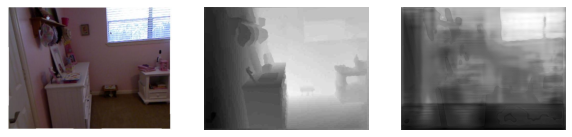

Model saved
Epoch :  2 Train loss:  2.504300465195008  MSE :  0.003237282647066909 Validation loss:  2.5475571274757387 Val MSE :  0.003346441932964599


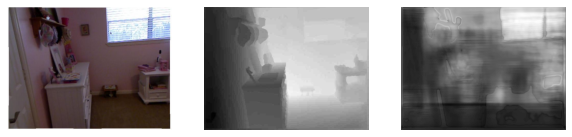

Model saved
Epoch :  3 Train loss:  2.468617068888094  MSE :  0.0031396846586143556 Validation loss:  2.538652188613497 Val MSE :  0.003427753143440718


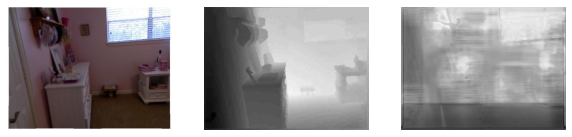

Model saved
Epoch :  4 Train loss:  2.440035925279721  MSE :  0.0030972826046194706 Validation loss:  2.4943186533862147 Val MSE :  0.0032597232781264975


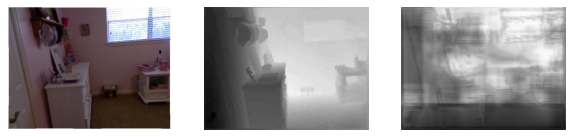

Model saved
Epoch :  5 Train loss:  2.414355494576965  MSE :  0.0030058664969643506 Validation loss:  2.4975650918894803 Val MSE :  0.0033260035867663635


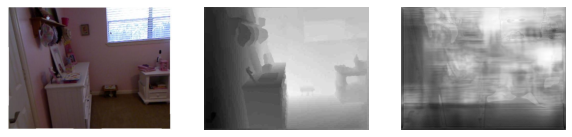

In [50]:
EPOCHS = 5
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 4*320*240

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_train = 0
  metric_val = 0
  model.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()
    # print(X_train.shape)
    Y_predict = model(X_train)

    l1_loss = l1_criterion(Y_train, Y_predict)

    # ssim_loss = torch.clamp((1 - ssim(Y_train, Y_predict, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

    loss = 0.1 * l1_loss + 1 * SSIM(Y_train, Y_predict)
    # loss = l1_loss
    
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_train += METRIC(Y_train, Y_predict).item()

  model.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model(X_val)

    l1_loss = l1_criterion(Y_val_pred, Y_val)

    # ssim_loss = torch.clamp((1 - ssim(Y_train, Y_predict, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

    loss = 0.1 * l1_loss + 1 * SSIM(Y_val_pred, Y_val)
    
    loss_aggregate_val += loss.item()
    metric_val += METRIC(Y_val, Y_val_pred).item()


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader), " MSE : ", metric_train/(len(train_loader)*N_pixels),
        "Validation loss: ", loss_aggregate_val/len(valid_loader), "Val MSE : ", metric_val/(len(valid_loader)*N_pixels))
  
  plot_image(model)
  plt.show()
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_l1_ssim.pt"
    torch.save(model.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()

In [52]:
def test(model, test_loader):
  loss_aggregate = 0
  metric_aggregate = 0
  model.train(False)
  for idx, (X_test, Y_test) in enumerate(test_loader):

    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    Y_test_pred = model(X_test)

    metric_aggregate += SSIM(Y_test_pred, Y_val).item()


  print("DSSIM loss: ", metric_aggregate/(len(test_loader)))

model_3 = NestedUNet()
model_save_path = r"../Data/model_unetpp_ssim.pt"
state = torch.load(model_save_path)

model_3.load_state_dict(state)
model_3 = model_3.to(device)

model_4 = NestedUNet()
model_save_path = r"../Data/model_l1_ssim.pt"
state = torch.load(model_save_path)

model_4.load_state_dict(state)
model_4 = model_4.to(device)

print("For SSIM : ")
test(model_3, test_loader)
print("For SSIM + L1 : ")
test(model_4, test_loader)

For SSIM : 
DSSIM loss:  0.2965866423886398
For SSIM + L1 : 
DSSIM loss:  0.35419150303150043


### Pretrained Model

The model architecture we used here is a U Net based on Densenet 169. 

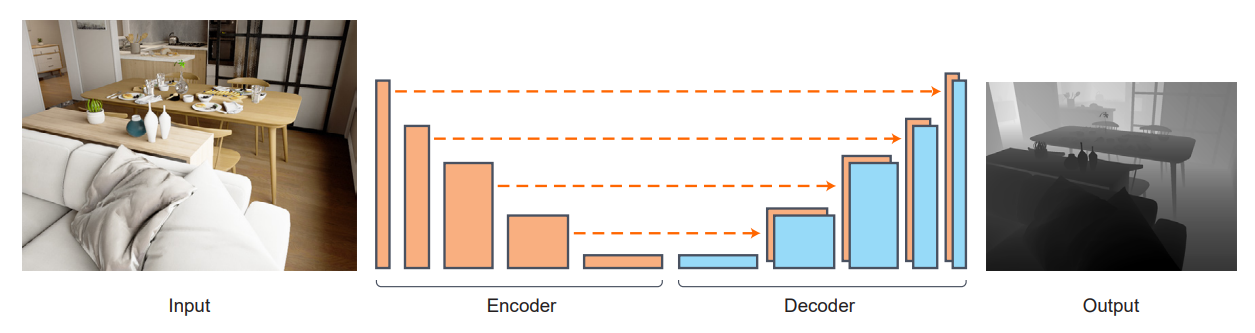

Here, the input is (3, 480, 640) and output is (240, 320), unlike our two architectures where we employed U-Net to generate the final image of size (480, 640) directly. The output is then upsampled using billinear interpolation to get the desired image.

DenseNet 169 : The DenseNet essentially for a given layer $l_i$ takes the output of all the previous layers $l_0$ to $l_{i-1}$ and produces an output with the required feature maps $k$ (i.e. the number of frames). Each block consists of this architecture, and the next block essentially is the downsampled version of the output of previous block. We have used the code for this from the available github repo and modified the loss function. 

In [ ]:
def plot_image_2(model_x):

  with torch.no_grad():
    X = torchvision.io.read_image('../Data/test/image/105.jpg').float()
    Y = torchvision.io.read_image('../Data/test/labels/105.jpg').float()
    X = X.to(device)
    Y = Y.to(device)

    Y = torch.squeeze(Y, 0)

    X = torch.unsqueeze(X, 0)
    Y_pred = torch.squeeze(model_x(X),0)

    X_dis = torch.squeeze(X, 0).cpu().numpy()
    Y_pred_dis = torch.squeeze(Y_pred,0).cpu().detach().numpy()

    figure = plt.figure(figsize=(10,7))

    figure.add_subplot(1,3,1)
    plt.imshow(np.transpose(X_dis, (1,2,0)).astype('int32'))
    plt.axis('off')

    figure.add_subplot(1,3,2)
    plt.imshow(Y.cpu().detach().numpy(), cmap="gray")
    plt.axis('off')

    figure.add_subplot(1,3,3)
    plt.imshow(1/Y_pred_dis, cmap="gray")
    plt.axis('off')


In [ ]:

from torchvision import models
import torch.nn.functional as F


class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder_pt(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder_pt, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder_pt(nn.Module):
    def __init__(self):
        super(Encoder_pt, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class PTModel(nn.Module):
    def __init__(self):
        super(PTModel, self).__init__()
        self.encoder = Encoder_pt()
        self.decoder = Decoder_pt()

    def forward(self, x):
        return self.decoder( self.encoder(x) )


Image with pre trained model


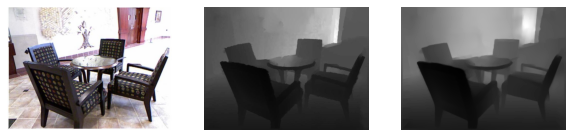

Epoch :  1 Train loss:  7.618664664991772  MSE :  0.08227961422349997 Validation loss:  7.488486326151881 Val MSE :  0.07958370078295127


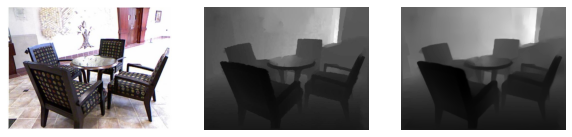

Model saved
Epoch :  2 Train loss:  7.6187149912658905  MSE :  0.08228077183518562 Validation loss:  7.488915675261925 Val MSE :  0.07958947200336676


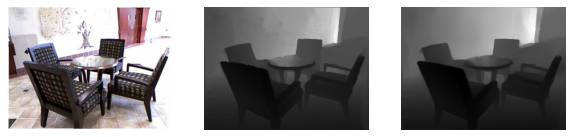

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_save_path = r"../Data/Dense_Depth_Pretrained.pt"

state = torch.load(model_save_path)

model = PTModel()
model.load_state_dict(state)
model = model.to(device)

print("Image with pre trained model")
plot_image_2(model)
plt.show()


OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)
l1_criterion = nn.L1Loss()
METRIC = torch.nn.MSELoss()


EPOCHS = 2
prev_loss = 10000
maxDepth = 1000
minDepth = 10

N_pixels = 320*240

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

OPTIMIZER = torch.optim.Adam(model_2.parameters(), lr=0.001)
LOSS = SSIM
LOSS_2 = torch.nn.L1Loss()
METRIC = torch.nn.MSELoss()

for epoch in range(EPOCHS):

  loss_aggregate_train = 0
  loss_aggregate_val = 0
  metric_aggregate_train = 0
  metric_aggregate_val = 0
  model.train(True)

  for idx, (X_train, Y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    OPTIMIZER.zero_grad()

    Y_predict = model(X_train)

    Y_predict = torch.clip(maxDepth/Y_predict, minDepth, maxDepth) / maxDepth
    
    loss = LOSS(Y_predict, Y_train[:, :, 0::2, 0::2]) + 0.1*LOSS_2(Y_predict, Y_train[:, :, 0::2, 0::2])
    
    metric = METRIC(Y_train[:,:,0::2,0::2], Y_predict)
    loss.backward()

    OPTIMIZER.step()

    loss_aggregate_train += loss.item()
    metric_aggregate_train += metric.item() 

  model.train(False)

  for idx, (X_val, Y_val) in enumerate(valid_loader):

    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    Y_val_pred = model(X_val)

    Y_val_pred = torch.clip(maxDepth/Y_val_pred, minDepth, maxDepth) / maxDepth

    loss = LOSS(Y_val_pred, Y_val[:, :, 0::2, 0::2]) + 0.1*LOSS_2(Y_val_pred, Y_val[:, :, 0::2, 0::2])

    metric = METRIC(Y_val[:,:,0::2,0::2], Y_val_pred) 

    loss_aggregate_val += loss.item()
    metric_aggregate_val += metric.item() 


  print("Epoch : ",epoch+1,"Train loss: ",loss_aggregate_train/len(train_loader), " MSE : ", metric_aggregate_train/(len(train_loader)*N_pixels),
        "Validation loss: ", loss_aggregate_val/len(valid_loader), "Val MSE : ", metric_aggregate_val/(len(valid_loader)*N_pixels))
  
  plot_image_2(model)
  plt.show()
  
  if loss_aggregate_val/len(valid_loader) < prev_loss:
    PATH = r"../Data/model_11-04-2022.pt"
    torch.save(model.state_dict(), PATH)
    prev_loss = loss_aggregate_val/len(valid_loader)
    print("Model saved")

  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : loss_aggregate_train/(len(train_loader)*N_pixels), 'Validation' : loss_aggregate_val/(len(valid_loader)*N_pixels) },
                    epoch + 1)
  writer.flush()


As we can see, the pretrained model gives amazing results, since it was trained for 24 hours on Nvidia Titan GPU. The weights are not updating since they are already at their optimum values.

## Learnings

In the implementation of this project, we were able to learn the following techniques.

* Pytorch (Specifically using existing data to generate dataset and data loaders.
* Custom Loss functions
* Transfer learning
* U Net and U Net ++ architecture
* DenseNet 169 architecture
* KL Divergence

## Conclusion



In this project we explored the depth and breadth of the state of the art technique implemented by [1] for Monocular depth estimation. 
We did a comparative study of different network architectures and loss functions for training the model. We also reproduced the results from the state of the art method along with our own.
Our implementation is novel because of the low data we have utilized to obtain the results with the lesser complex model requiring lower computational complexity.  

## References

* a. https://matplotlib.org/3.5.0/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html
* b. https://pytorch.org/tutorials/
* c. https://matplotlib.org/2.2.5/gallery/mplot3d/rotate_axes3d.html
* d. https://learnopencv.com/paired-image-to-image-translation-pix2pix/
* e. High Quality Monocular Depth Estimation via Transfer Learning, Ibraheem Alhashim and Peter Wonka, 2019